# Cal-CRAI Domain Score: Governance

**Order of operations**: 
1) Metric handling \
   1a - Retrieve data \
   1b - Min-max standardization \
   1c - Set vulnerability orientation (positive for when a larger value represents greater vulnerability, negative for when a larger value corresponds to decreased vulnerability)

2) Calculate indicators \
   2a - Min-max standardization \
   2b - Finalize domain score
   
3) Visualize, save, and export domain score dataframe

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.cal_crai_plotting import plot_domain_score, plot_region_domain
from scripts.utils.cal_crai_calculations import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


Process and merge Governance metric files together

In [3]:
# domain-specific
domain_prefix = 'governance_'

input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 12 CSV files within governance_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_governance_metrics.csv


Take a look at the resulting dictionary: We will use this later to refactor 'resilient' metrics!

In [4]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'num_police_officers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'nfip_participation',
  'percent_under_timber_management',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_flood_policies',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'total_emergency_management_funding',
  'num_registered_nurses_employed_per_10000']}

Now, take a look at the merged singluar csv file

In [5]:
# read-in and view processed data
processed_governance_df = pd.read_csv(merged_output_file)
processed_governance_df

,GEOID,total_hazard_mitigation_funding,housing_units_with_mortgage,num_police_officers_employed_per_10000,percent_sampled_wells_contaminated,num_fire_stations_per_10000_people,nfip_participation,percent_under_timber_management,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_flood_policies,num_firefighting_and_prevention_workers_employed_per_10000,total_emergency_management_funding,num_registered_nurses_employed_per_10000
0,6085504321,7.402136e+07,67.5,11.190345,NaN,0.443440,1.0,0.340426,4.773504,6950.0,3.077997,4309742.0,72.776369
1,6085504410,7.402136e+07,67.5,11.190345,NaN,0.443440,1.0,0.340426,4.773504,6950.0,3.077997,4309742.0,72.776369
2,6085507003,7.402136e+07,67.5,11.190345,NaN,0.443440,1.0,0.340426,4.773504,6950.0,3.077997,4309742.0,72.776369
3,6085507004,7.402136e+07,67.5,11.190345,NaN,0.443440,1.0,0.340426,4.773504,6950.0,3.077997,4309742.0,72.776369
4,6085502204,7.402136e+07,67.5,11.190345,NaN,0.443440,1.0,0.340426,4.773504,6950.0,3.077997,4309742.0,72.776369
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,1.509280e+08,67.0,16.219313,100.0,0.428316,1.0,NaN,4.724072,6462.0,9.495384,6428182.0,79.852559
9125,6059001304,1.509280e+08,67.0,16.219313,NaN,0.428316,1.0,NaN,4.724072,6462.0,9.495384,6428182.0,79.852559
9126,6059001401,1.509280e+08,67.0,16.219313,NaN,0.428316,1.0,NaN,4.724072,6462.0,9.495384,6428182.0,79.852559
9127,6013367200,2.929703e+07,72.2,23.265855,NaN,0.550468,1.0,NaN,7.052866,2106.0,7.611934,2720086.0,85.967550


### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in processed_governance_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_governance_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_governance_metrics_df = min_max_metrics[selected_columns]
min_max_standardized_governance_metrics_df.head()

### 1c) Set resilience orientation
* High values indicate resiliency
* Low values indicate vulnerablility

Some metrics indicate a communities vulnerablity rather than resilience. For example, 'percent_sampled_wells_contaminated' represents a communities vulnerability to water contamination. For this metric, the higher the number, the more vulnerable. So we identify these 'vulnerable' metrics with our `metric_vulnerable_resilient_dict` dictionary and subtract their values from 1 so all high values indicate resiliency

In [8]:
metric_vulnerable_resilient_dict

{'vulnerable': ['percent_sampled_wells_contaminated'],
 'resilient': ['total_hazard_mitigation_funding',
  'housing_units_with_mortgage',
  'num_police_officers_employed_per_10000',
  'num_fire_stations_per_10000_people',
  'nfip_participation',
  'percent_under_timber_management',
  'num_emergency_medical_technicians_and_paramedics_employed_per_10000',
  'num_flood_policies',
  'num_firefighting_and_prevention_workers_employed_per_10000',
  'total_emergency_management_funding',
  'num_registered_nurses_employed_per_10000']}

In [9]:
# Access the vulnerable column names from the dictionary
vulnerable_columns = metric_vulnerable_resilient_dict['vulnerable']

# Identify columns in the DataFrame that contain any of the vulnerable column names as substrings
vulnerable_columns_in_df = [col for col in min_max_standardized_governance_metrics_df.columns 
                           if any(resilient_col in col for resilient_col in vulnerable_columns)]

# Create a new DataFrame with the adjusted vulnerable columns
adjusted_vulnerable_df = min_max_standardized_governance_metrics_df.copy()

# Subtract the standardized vulnerable columns from one and store the result in the new DataFrame
adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df] = (
    1 - adjusted_vulnerable_df.loc[:, vulnerable_columns_in_df]
)

# View results
adjusted_vulnerable_df.head()

,GEOID,total_hazard_mitigation_funding_min_max_standardized,housing_units_with_mortgage_min_max_standardized,num_police_officers_employed_per_10000_min_max_standardized,percent_sampled_wells_contaminated_min_max_standardized,num_fire_stations_per_10000_people_min_max_standardized,nfip_participation_min_max_standardized,percent_under_timber_management_min_max_standardized,num_emergency_medical_technicians_and_paramedics_employed_per_10000_min_max_standardized,num_flood_policies_min_max_standardized,num_firefighting_and_prevention_workers_employed_per_10000_min_max_standardized,total_emergency_management_funding_min_max_standardized,num_registered_nurses_employed_per_10000_min_max_standardized
0,6085504321,0.089965,0.716346,0.00015,NaN,0.010454,1.0,0.067503,0.001814,0.34529,0.0,0.212976,0.004101
1,6085504410,0.089965,0.716346,0.00015,NaN,0.010454,1.0,0.067503,0.001814,0.34529,0.0,0.212976,0.004101
2,6085507003,0.089965,0.716346,0.00015,NaN,0.010454,1.0,0.067503,0.001814,0.34529,0.0,0.212976,0.004101
3,6085507004,0.089965,0.716346,0.00015,NaN,0.010454,1.0,0.067503,0.001814,0.34529,0.0,0.212976,0.004101
4,6085502204,0.089965,0.716346,0.00015,NaN,0.010454,1.0,0.067503,0.001814,0.34529,0.0,0.212976,0.004101


## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [10]:
domain_prefix[:-1]

'governance'

In [11]:
averaged_indicators_governance_systems = compute_averaged_indicators(
    adjusted_vulnerable_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_governance_systems

,GEOID,emergency_response,personal_preparedness,community_preparedness,natural_resource_conservation
0,6085504321,0.003304,0.530818,0.544983,0.067503
1,6085504410,0.003304,0.530818,0.544983,0.067503
2,6085507003,0.003304,0.530818,0.544983,0.067503
3,6085507004,0.003304,0.530818,0.544983,0.067503
4,6085502204,0.003304,0.530818,0.544983,0.067503
...,...,...,...,...,...
9124,6059001303,0.004151,0.506677,0.591781,0.000000
9125,6059001304,0.004151,0.506677,0.591781,NaN
9126,6059001401,0.004151,0.506677,0.591781,NaN
9127,6013367200,0.008976,0.523469,0.517768,NaN


Save Indicator dataframe as a csv

In [12]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
averaged_indicators_governance_systems.to_csv(indicator_filename, index=False)

Sum the indicator columns together to calculate the domain score
* essentially summing all columns except for 'GEOID'

In [13]:
columns_to_sum = [col for col in averaged_indicators_governance_systems.columns if col != 'GEOID']
summed_indicators_governance_systems = compute_summed_indicators(
    df=averaged_indicators_governance_systems, 
    columns_to_sum=columns_to_sum,
    domain_prefix=domain_prefix
)

Indicator sum min value: 0.0
Indicator sum max value: 2.5913591793189683


# 2a) Min-max standardize the summed columns

In [14]:
columns_to_process = [col for col in summed_indicators_governance_systems.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_governance_systems, columns_to_process)
min_max_domain

All standardized columns are within the [0, 1] range (considering tolerance).


,GEOID,summed_indicators_governance_domain_min,summed_indicators_governance_domain_max,summed_indicators_governance_domain_min_max_standardized
0,6085504321,0.0,2.591359,0.442474
1,6085504410,0.0,2.591359,0.442474
2,6085507003,0.0,2.591359,0.442474
3,6085507004,0.0,2.591359,0.442474
4,6085502204,0.0,2.591359,0.442474
...,...,...,...,...
9124,6059001303,0.0,2.591359,0.425494
9125,6059001304,0.0,2.591359,0.425494
9126,6059001401,0.0,2.591359,0.425494
9127,6013367200,0.0,2.591359,0.405275


# 2b) Finalize domain score
* Isolate to census tract and summed standardized columns
* Rename tract to GEOID for merging
* Rename domain score column
* Add a zero at the beginning of the GEOID to match census tract that will be merged

In [15]:
governance_domain_score = min_max_domain[['GEOID', 'summed_indicators_governance_domain_min_max_standardized']].copy()

# GEOID handling
governance_domain_score['GEOID'] = governance_domain_score['GEOID'].apply(lambda x: '0' + str(x))
governance_domain_score['GEOID'] = governance_domain_score['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
governance_domain_score = governance_domain_score.rename(columns={'summed_indicators_governance_domain_min_max_standardized':'governance_domain_score'})
governance_domain_score.head()

,GEOID,governance_domain_score
0,06085504321,0.442474
1,06085504410,0.442474
2,06085507003,0.442474
3,06085507004,0.442474
4,06085502204,0.442474


## Step 3: Visualize, save, and export domain score


Let's look at some summary statistics for this domain:

In [16]:
domain_summary_stats(governance_domain_score, 'governance_domain_score')

Median governance_domain_score domain value: 0.4254943891957325
Mean governance_domain_score domain value: 0.46942461526913803


Now let's visualize the entire domain!

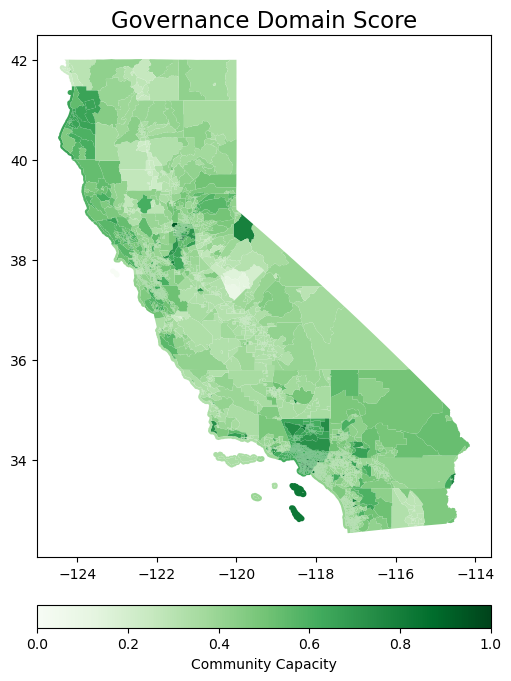

In [17]:
plot_domain_score(governance_domain_score, column_to_plot='governance_domain_score', domain=domain_prefix)

### We can also visualize specific areas!
Here we'll use the specialized plotting function `plot_region_domain` function, which can handle county identifiers (their corresponding FIPS code) and pre-defined CA regions (listed below). For more information on the function, type `help(plot_region_domain)` to display additional context for all arguments. 

Pre-defined regions include: `bay_area`, `central_region`, `inland_deserts`, `north_central`, `northern`, `south_coast`, `slr_coast`. 

CA County FIPS Code Look-Up Table
|County: Code|County: Code|County: Code|County: Code|
|-----|----|-----|-----|
|Alameda: 001|Lassen: 035|San Benito: 069|Tehama: 103|
|Alpine: 003|Los Angeles: 037|San Bernardino: 071|Trinity: 105|
|Amador: 005|Madera: 039|San Diego: 073|Tulare: 107|
|Butte: 007|Marin: 041|San Francisco: 075|Tuolumne: 109|
|Calaveras: 009|Mariposa: 043|San Joaquin: 077|Ventura: 111|
|Colusa: 013|Mendocino: 045|San Luis Obispo: 079|Yolo: 113|
|Contra Costa: 015|Merced: 047|San Mateo: 081|Yuba: 115|
|Del Norte: 017|Modoc: 049| Santa Barbara: 083|
|El Dorado: 019|Mono: 051|Santa Clara: 085|
|Fresno: 019|Monterey: 053|Santa Cruz: 087|
|Glenn: 021|Napa: 055|Shasta: 089|
|Humboldt: 023|Nevada: 057|Sierra: 091|
|Imperial: 025|Orange: 059|Siskiyou: 095|
|Inyo: 027|Placer: 061|Solano: 095|
|Kern: 029|Plumas: 063|Sonoma: 097|
|Kings: 031|Riverside: 065|Stanislaus: 099|
|Lake: 033|Sacramento: 067|Sutter: 101|

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels. Below are a few example of each of these plotting scenarios. 
`help(plot_region_domain)`

Number of invalid geometries: 0


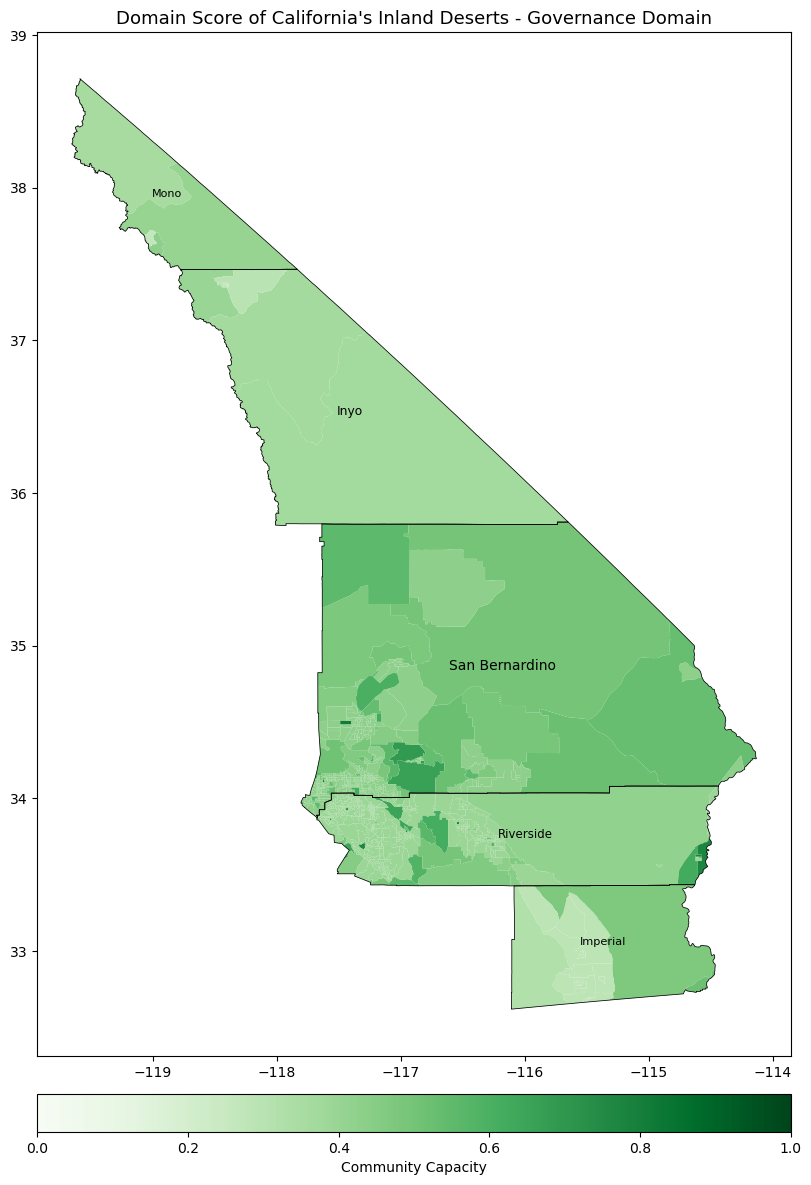

In [18]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   region='inland_deserts', 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


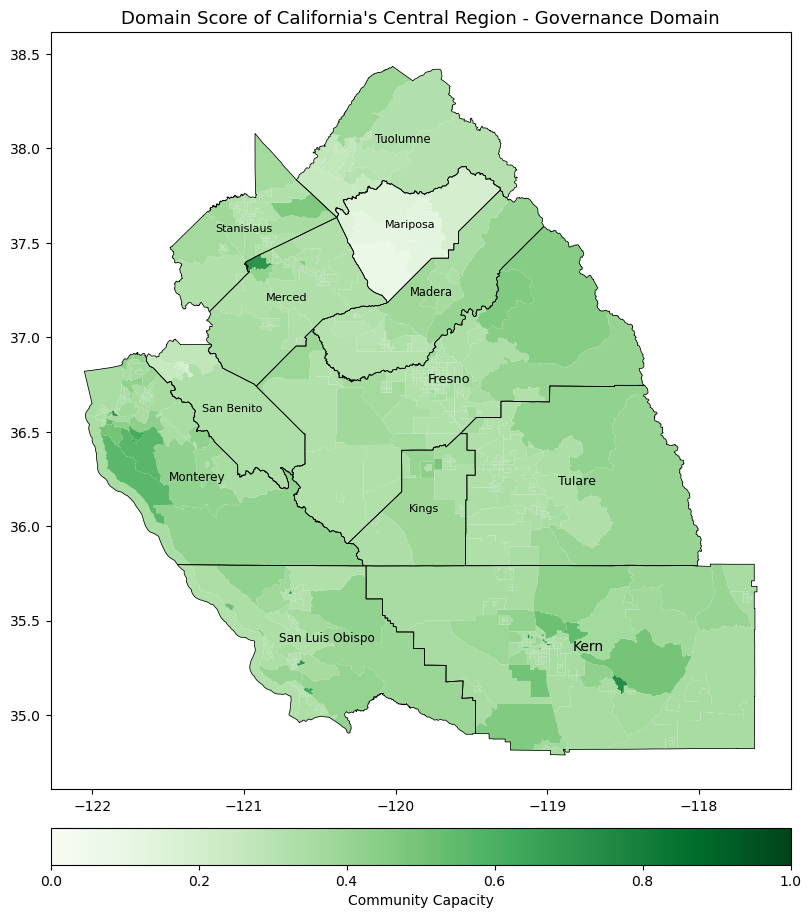

In [19]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   region='central_region', 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


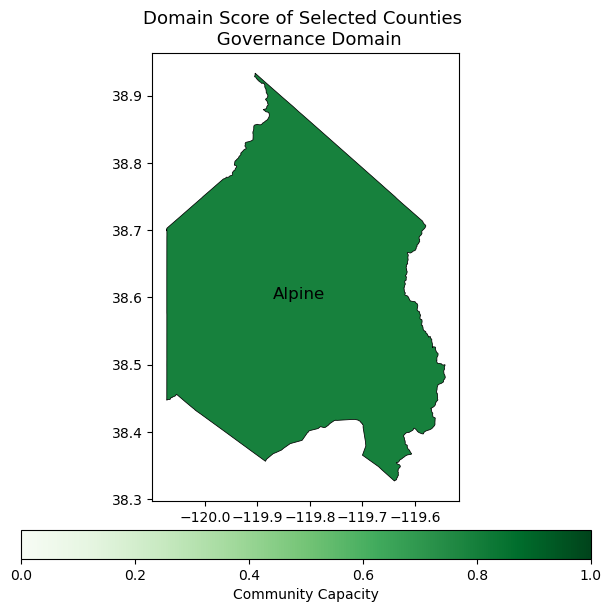

In [20]:
list_of_counties = ['003']
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   counties_to_plot=list_of_counties, 
                   savefig=False, 
                   font_color='black')

Number of invalid geometries: 0


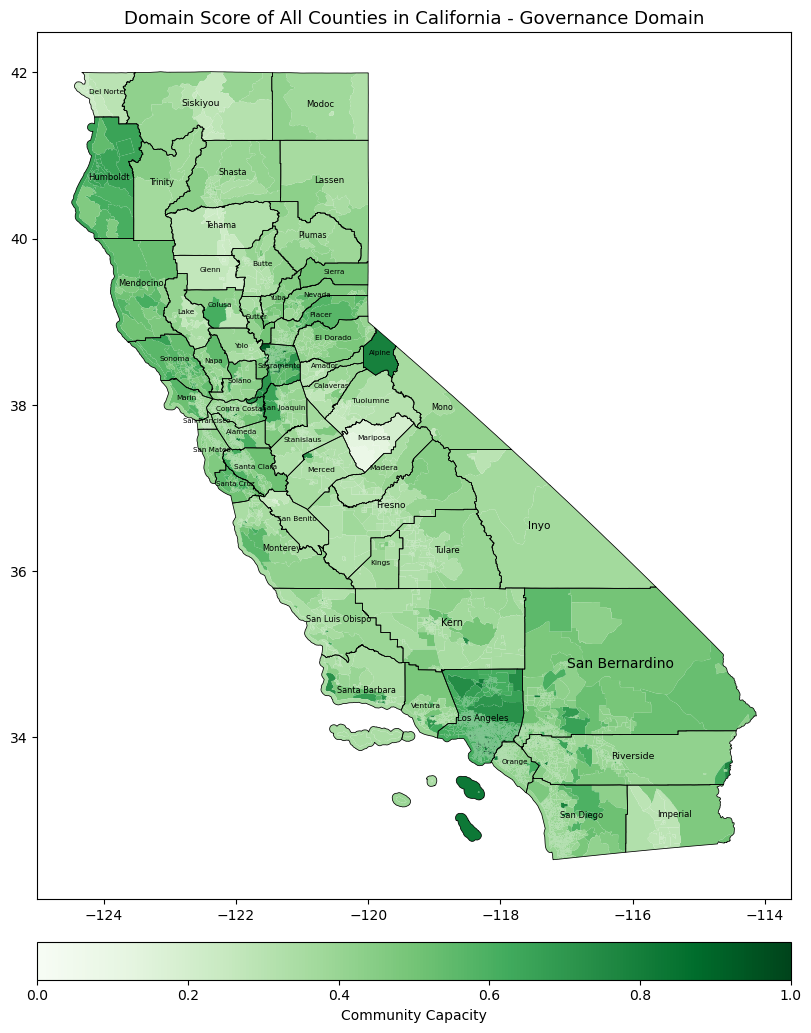

In [21]:
plot_region_domain(governance_domain_score, 
                   column_to_plot='governance_domain_score',
                   domain=domain_prefix, 
                   domain_label_map={domain_prefix: 'Governance Domain'}, 
                   plot_all=True, 
                   savefig=False, 
                   font_color='black')

## Export the final domain csv file

In [22]:
# set-up file for export
domain_filename = '{}domain_score.csv'.format(domain_prefix)
governance_domain_score.to_csv(domain_filename, index=False)

## Upload the indicator and domain score csv files to AWS

In [23]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

governance_domain_averaged_indicators.csv uploaded to AWS
governance_domain_score.csv uploaded to AWS
